In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path_data_DCO = "/Users/eresther/Documents/Work/PhD/Codes/Data_DCO"
path_data_PSTH = "/Users/eresther/Documents/Work/PhD/Codes/Data_PSTH"

AREAS = ["A1", "dPEG", "VPr", "PFC"]
TASKS = ["PTD", "CLK"]
CTXS = ["a", "p"]
STIMS = ["R", "T"]
training = True

In [3]:
W = {area: None for area in AREAS}
for area in AREAS:
    W[area] = xr.open_dataarray(f"{path_data_DCO}/Wt_{training}_{area}.nc")

Wact = {area: None for area in AREAS}
for area in AREAS:
    Wact[area] = xr.open_dataarray(f"{path_data_DCO}/Wact_{training}_{area}.nc")

X = {area: None for area in AREAS}
for area in AREAS:
    X[area] = xr.open_dataarray(f"{path_data_PSTH}/Z_{training}_{area}_valid.nc")

In [4]:
# Activities
X['A1']

<xarray.DataArray 'Z-scores' (units: 26, time: 38, trials: 2073)> Size: 16MB
[2048124 values with dtype=float64]
Coordinates:
  * trials   (trials) int64 17kB 0 1 3 10 14 16 ... 1603 1679 1680 1686 1689
    task     (trials) <U3 25kB ...
    ctx      (trials) <U1 8kB ...
    stim     (trials) <U1 8kB ...
    train_0  (trials) bool 2kB ...
    test_0   (trials) bool 2kB ...
    train_1  (trials) bool 2kB ...
    test_1   (trials) bool 2kB ...
    train_2  (trials) bool 2kB ...
    test_2   (trials) bool 2kB ...
  * units    (units) <U10 1kB 'lem046d-j1' 'avo047a-u1' ... 'lem045c-p1'
  * time     (time) float64 304B -0.35 -0.3 -0.25 -0.2 ... 1.35 1.4 1.45 1.5
Attributes:
    area:      A1
    training:  1
    errors:    0
    k:         3

In [5]:
# Decoders

#W['A1']

print(Wact['VPr']['set_sizes'].values)
Wact['VPr']

[24 24 24 24 24]


<xarray.DataArray 'Residual-specific decoders' (units: 127, time: 38,
                                                decoders: 4, folds: 3,
                                                models: 101, batches: 5)> Size: 234MB
[29245560 values with dtype=float64]
Coordinates: (12/14)
  * units       (units) <U12 6kB 'avo109b-a1' 'lemon082b-d1' ... 'avo070a-c1'
  * time        (time) float64 304B -0.35 -0.3 -0.25 -0.2 ... 1.35 1.4 1.45 1.5
  * decoders    (decoders) <U15 240B 'GoPTD-NoGoPTD-p' ... 'GoCLK-NoGoCLK-a'
  * folds       (folds) <U7 84B 'train_0' 'train_1' 'train_2'
  * models      (models) <U7 3kB 'true' 'perm_0' ... 'perm_98' 'perm_99'
  * batches     (batches) int64 40B 0 1 2 3 4
    ...          ...
    task1       (decoders) <U3 48B ...
    ctx1        (decoders) <U1 16B ...
    stim1       (decoders) <U1 16B ...
    task0       (decoders) <U3 48B ...
    ctx0        (decoders) <U1 16B ...
    stim0       (decoders) <U1 16B ...
Attributes:
    area:      VPr
    training:  1
    errors:    0
    k:         3

In [6]:
# Define useful variables
print(Wact['A1']['set_sizes'].values)
ntpts = len(Wact['A1']['time'].values)
nfolds = Wact['A1'].attrs['k']
set_size = 24

def get_nbatches(area):
    return len(Wact[area]['batches'].values)

print(ntpts, nfolds, get_nbatches("A1"))


[24 24]
38 3 2


In [7]:
# Keep true models and active-specific decoders for each task
W_PTD = {area: Wact[area].sel(decoders='GoPTD-NoGoPTD-a', models='true') for area in AREAS}
W_CLK = {area: Wact[area].sel(decoders='GoCLK-NoGoCLK-a', models='true') for area in AREAS}

W_PTD['A1']

<xarray.DataArray 'Residual-specific decoders' (units: 26, time: 38, folds: 3,
                                                batches: 2)> Size: 47kB
[5928 values with dtype=float64]
Coordinates: (12/14)
  * units       (units) <U10 1kB 'lem046d-j1' 'avo047a-u1' ... 'lem045c-p1'
  * time        (time) float64 304B -0.35 -0.3 -0.25 -0.2 ... 1.35 1.4 1.45 1.5
    decoders    <U15 60B 'GoPTD-NoGoPTD-a'
  * folds       (folds) <U7 84B 'train_0' 'train_1' 'train_2'
    models      <U7 28B 'true'
  * batches     (batches) int64 16B 0 1
    ...          ...
    task1       <U3 12B ...
    ctx1        <U1 4B ...
    stim1       <U1 4B ...
    task0       <U3 12B ...
    ctx0        <U1 4B ...
    stim0       <U1 4B ...
Attributes:
    area:      A1
    training:  1
    errors:    0
    k:         3

In [8]:
# Compute projections of the activity in each condition onto the decoders
P_on_PTD = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
P_on_CLK = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_PTD = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_CLK = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_PTD = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_CLK = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}

for W_task, P_on_task, STD_on_task, SEM_on_task in zip([W_PTD, W_CLK], [P_on_PTD, P_on_CLK], [STD_on_PTD, STD_on_CLK], [SEM_on_PTD, SEM_on_CLK]):
    for area in AREAS:
        for f in range(nfolds):
            for b in range(get_nbatches(area)):
                    print(f"*** Area: {area}, Fold: {f}, Batch: {b} ***")
                    w = W_task[area].sel(folds=f'train_{f}', batches=b).values # (nunits, ntpts)
                    print(f"Shape W: {w.shape}")
                    # Display the number of nan among all the values of the decoders (it suffices to check the first time point)
                    print(f"Number of NaN weights (units): {np.sum(np.isnan(w[:,0]))} / {w.shape[0]}") # w.shape[0] is the number of units
                    X_area = X[area].sel(trials=X[area][f'test_{f}'].values) # retain the right test fold (nunits, ntpts, ntrials_test_fold_f)
                    for t in TASKS:
                        for c in CTXS:
                            for s in STIMS:
                                print(f"-- Task: {t}, Context: {c}, Stimulus: {s}")
                                x = X_area.sel(trials=(X_area['task'].values==t)&(X_area['ctx'].values==c)&(X_area['stim'].values==s)).values # (nunits, ntpts, ntrials_condition)
                                print(f"   Shape X: {x.shape}")
                                # Display the number of NaN among all the values of the activity
                                print(f"   Number of NaN activity: {np.sum(np.isnan(x))} / {np.prod(x.shape)}") # np.prod(x.shape) is the total number of values in x
                                # Compute the dot product (add a new axis to w to broadcast)
                                product = w[:,:,np.newaxis] * x # (nunits, ntpts, ntrials_condition)
                                dot = np.nansum(product, axis=0) # sum across units -> (ntpts, ntrials_condition)
                                # Check again the number of NaNs : if the number of NaN is 0 in x, it should be 0 in dot
                                print(f"   Number of NaN dot product: {np.sum(np.isnan(dot))} / {np.prod(dot.shape)}")
                                # Compute the trial averaged activity
                                P_on_task[area][t][c][s][:, f, b] = np.nanmean(dot, axis=1)
                                # Check the number of NaN in the trial averaged activity
                                print(f"   Number of NaN trial averaged activity: {np.sum(np.isnan(P_on_task[area][t][c][s][:, f, b]))} / {P_on_task[area][t][c][s][:, f, b].size}")
                                # Compute the std across trials
                                STD_on_task[area][t][c][s][:, f, b] = np.nanstd(dot, axis=1)
                                # Compute the SEM across trials
                                SEM_on_task[area][t][c][s][:, f, b] = STD_on_task[area][t][c][s][:, f, b] / np.sqrt(x.shape[2])
            print("------------")

*** Area: A1, Fold: 0, Batch: 0 ***
Shape W: (26, 38)
Number of NaN weights (units): 2 / 26
-- Task: PTD, Context: a, Stimulus: R
   Shape X: (26, 38, 5)
   Number of NaN activity: 0 / 4940
   Number of NaN dot product: 0 / 190
   Number of NaN trial averaged activity: 0 / 38
-- Task: PTD, Context: a, Stimulus: T
   Shape X: (26, 38, 5)
   Number of NaN activity: 0 / 4940
   Number of NaN dot product: 0 / 190
   Number of NaN trial averaged activity: 0 / 38
-- Task: PTD, Context: p, Stimulus: R
   Shape X: (26, 38, 5)
   Number of NaN activity: 0 / 4940
   Number of NaN dot product: 0 / 190
   Number of NaN trial averaged activity: 0 / 38
-- Task: PTD, Context: p, Stimulus: T
   Shape X: (26, 38, 5)
   Number of NaN activity: 0 / 4940
   Number of NaN dot product: 0 / 190
   Number of NaN trial averaged activity: 0 / 38
-- Task: CLK, Context: a, Stimulus: R
   Shape X: (26, 38, 5)
   Number of NaN activity: 0 / 4940
   Number of NaN dot product: 0 / 190
   Number of NaN trial averaged 

In [9]:
# Average results across folds and batches to keep only the time dimension (axis 0)
P_on_PTD_avg = {area: {task: {ctx: {stim: np.nanmean(P_on_PTD[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
P_on_CLK_avg = {area: {task: {ctx: {stim: np.nanmean(P_on_CLK[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_PTD_avg = {area: {task: {ctx: {stim: np.nanmean(STD_on_PTD[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_CLK_avg = {area: {task: {ctx: {stim: np.nanmean(STD_on_CLK[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_PTD_avg = {area: {task: {ctx: {stim: np.nanmean(SEM_on_PTD[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_CLK_avg = {area: {task: {ctx: {stim: np.nanmean(SEM_on_CLK[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}

print(P_on_CLK_avg["A1"]["PTD"]["a"]["R"].shape)

(38,)


In [10]:
# Define colors and linestyles
colors = {'PTD': {'a': {'R': 'blue', 'T': 'red'}, 'p': {'R': 'navy', 'T': 'tomato'}},
          'CLK': {'a': {'R': 'turquoise', 'T': 'magenta'}, 'p': {'R': 'purple', 'T': 'orange'}}}
linestyles = {'on_PTD': '-', 'on_CLK': '--'}

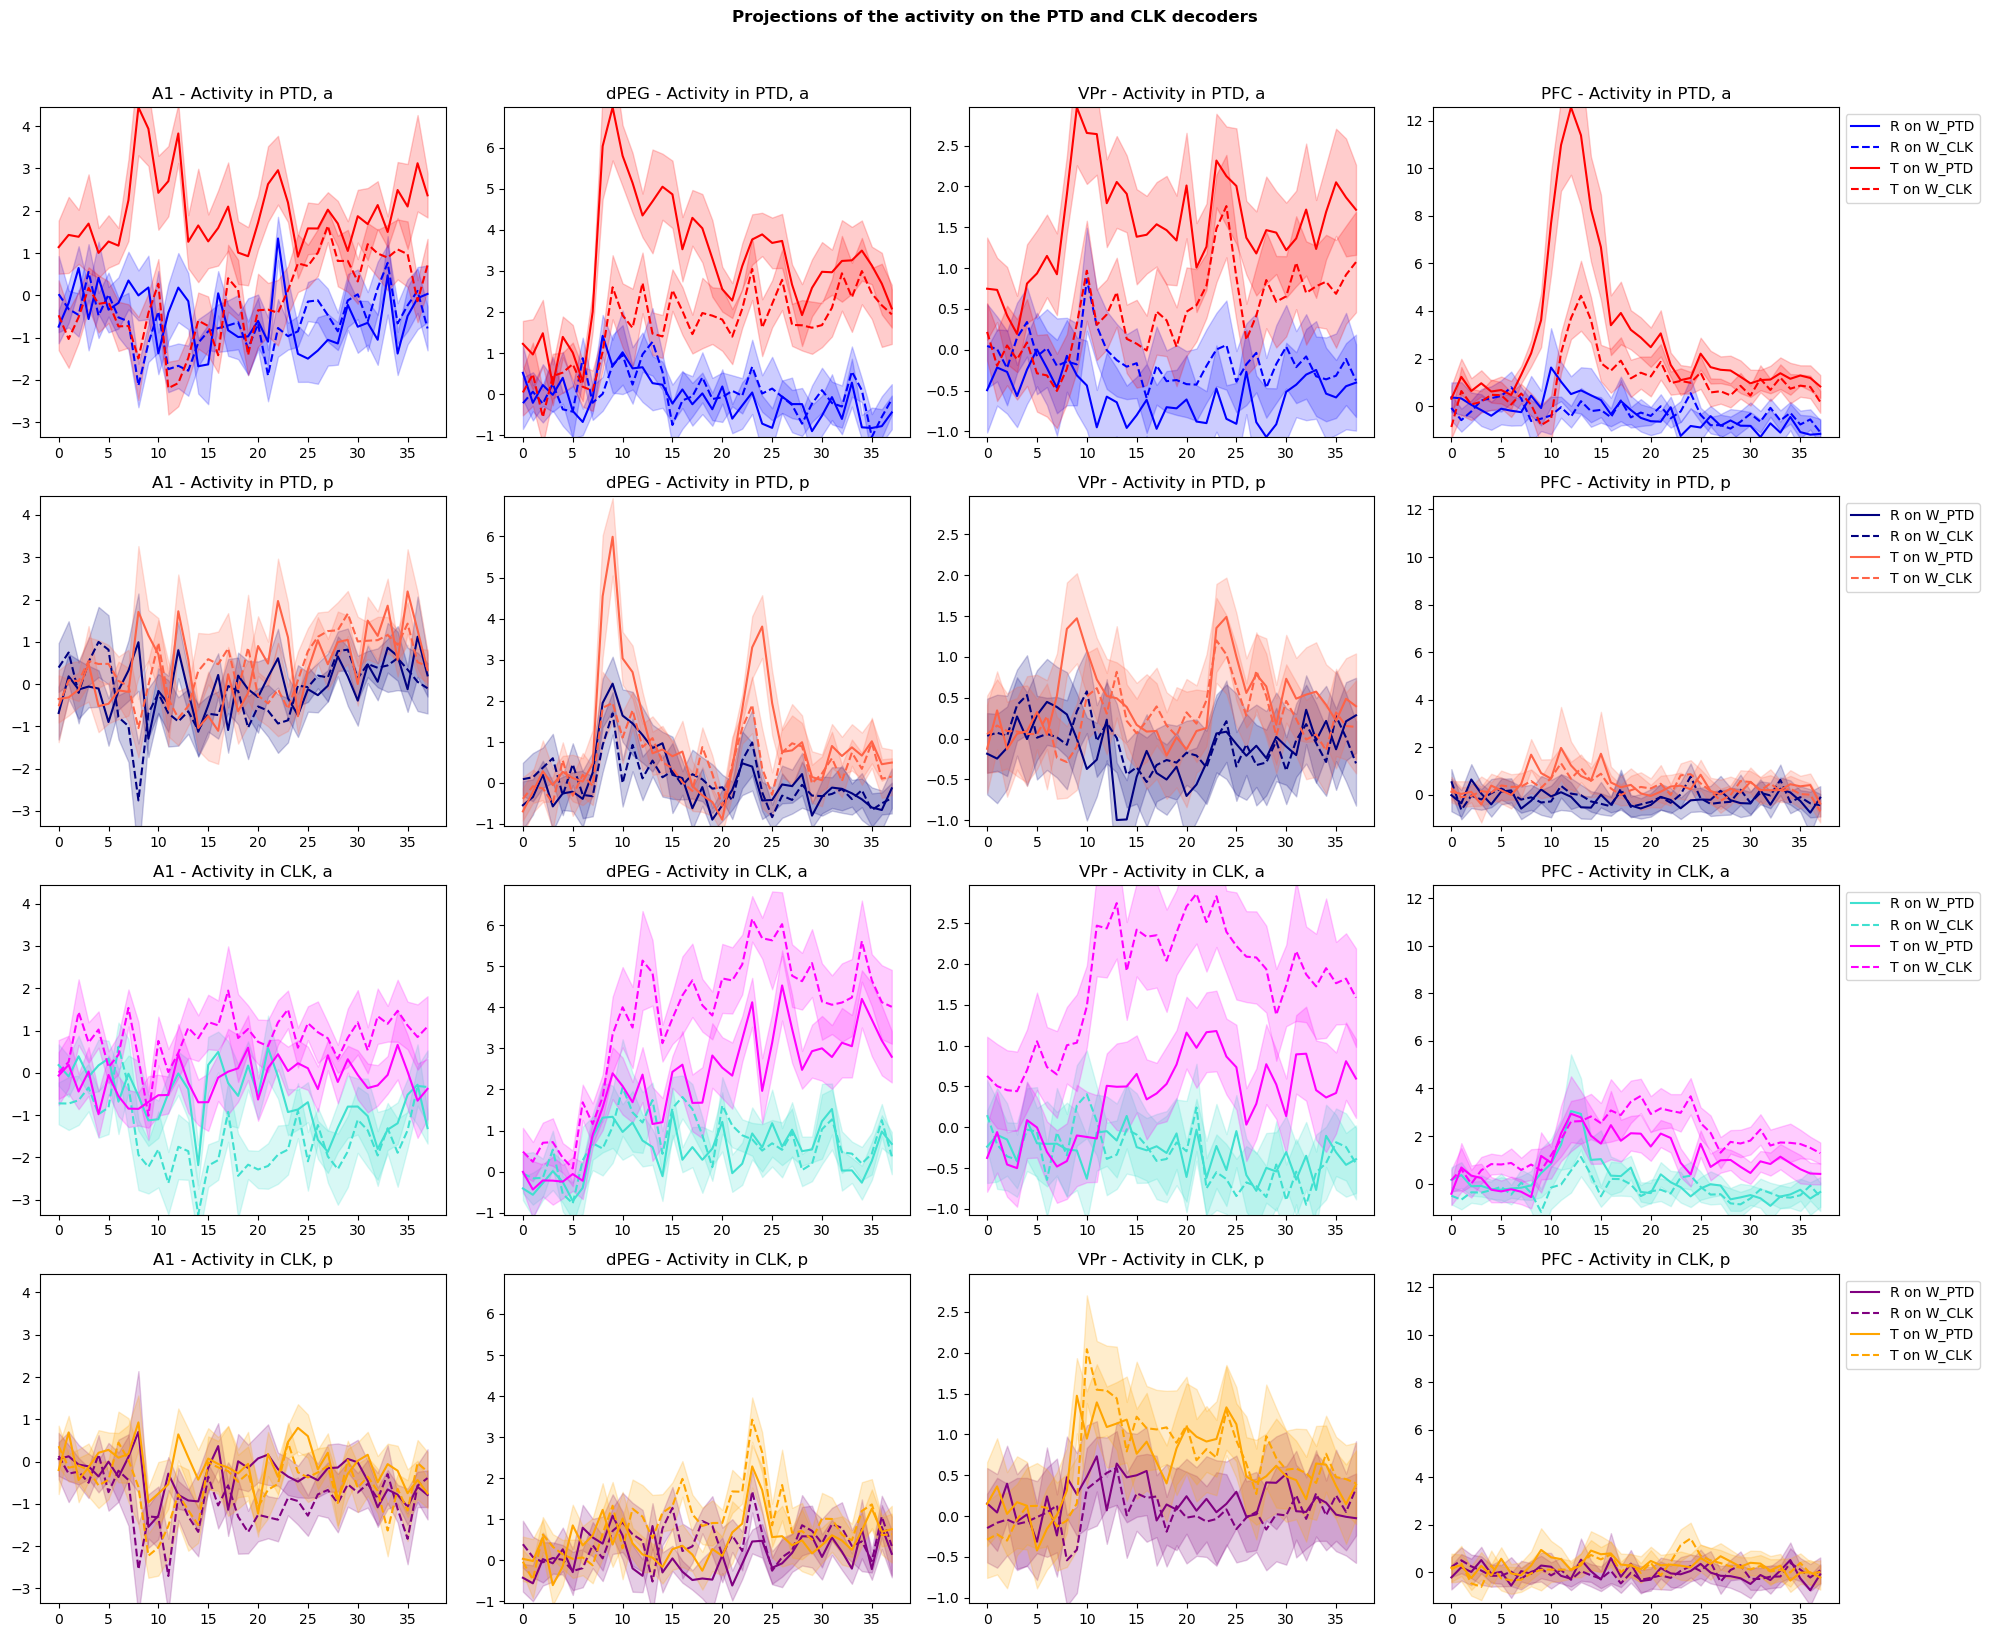

In [11]:
# FIG1: Time courses
nrows = len(TASKS) * len(CTXS)
ncols = len(AREAS)


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
fig.suptitle("Projections of the activity on the PTD and CLK decoders", weight='bold', y=1.02)

# Initialize lists to store min and max y-values for each column
y_min = [np.inf] * ncols
y_max = [-np.inf] * ncols

# First pass: determine the global y-axis limits for each column
for i, t in enumerate(TASKS):
    for j, c in enumerate(CTXS):
        for k, area in enumerate(AREAS):
            for s in STIMS:
                data_PTD = P_on_PTD_avg[area][t][c][s]
                data_CLK = P_on_CLK_avg[area][t][c][s]
                y_min[k] = min(y_min[k], data_PTD.min(), data_CLK.min())
                y_max[k] = max(y_max[k], data_PTD.max(), data_CLK.max())

# Second pass: plot the data and set the y-axis limits
for i, t in enumerate(TASKS):
    for j, c in enumerate(CTXS):
        for k, area in enumerate(AREAS):
            ax = axes[i*len(CTXS)+j, k]
            for s in STIMS:
                # Plot PTD data with shaded area for STD
                ax.plot(P_on_PTD_avg[area][t][c][s], label=f"{s} on W_PTD", color=colors[t][c][s], linestyle=linestyles['on_PTD'])
                ax.fill_between(range(len(P_on_PTD_avg[area][t][c][s])), 
                                P_on_PTD_avg[area][t][c][s] - SEM_on_PTD_avg[area][t][c][s], 
                                P_on_PTD_avg[area][t][c][s] + SEM_on_PTD_avg[area][t][c][s], 
                                color=colors[t][c][s], alpha=0.2)
                
                # Plot CLK data with shaded area for STD
                ax.plot(P_on_CLK_avg[area][t][c][s], label=f"{s} on W_CLK", color=colors[t][c][s], linestyle=linestyles['on_CLK'])
                ax.fill_between(range(len(P_on_CLK_avg[area][t][c][s])), 
                                P_on_CLK_avg[area][t][c][s] - SEM_on_CLK_avg[area][t][c][s], 
                                P_on_CLK_avg[area][t][c][s] + SEM_on_CLK_avg[area][t][c][s], 
                                color=colors[t][c][s], alpha=0.2)
                
            ax.set_title(f"{area} - Activity in {t}, {c}")
            ax.set_ylim(y_min[k], y_max[k])

        if area == "PFC":
            # Add a single legend in this plot for the entire row
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.tight_layout()
plt.show()

In [12]:
# Keep a single decoder for each task that maximizes the distinction between the two stim in the active condition for the same task

W_PTD_sel = {area: np.full((nfolds, get_nbatches(area)), fill_value=None) for area in AREAS}
W_CLK_sel = {area: np.full((nfolds, get_nbatches(area)), fill_value=None) for area in AREAS}

# Compute the difference betwee R and T projections across time points
D_PTD = {area: np.abs(P_on_PTD[area]['PTD']['a']['R'] - P_on_PTD[area]['PTD']['a']['T']) for area in AREAS}  # (ntpts, nfolds, nbatches)
D_CLK = {area: np.abs(P_on_CLK[area]['CLK']['a']['R'] - P_on_CLK[area]['CLK']['a']['T']) for area in AREAS}  # (ntpts, nfolds, nbatches)
print(D_PTD["A1"].shape)

for area in AREAS:
    for f in range(nfolds):
        for b in range(get_nbatches(area)):
            print(f"*** Area: {area}, Fold: {f}, Batch: {b} ***")
            w = W_task[area].sel(folds=f'train_{f}', batches=b).values # (nunits, ntpts)
            for task, W_task_sel, D_task in zip(TASKS, [W_PTD_sel, W_CLK_sel], [D_PTD, D_CLK]):
                d = D_task[area][:, f, b] # (ntpts,)
                # Find the time point of the maximum difference
                t_max = np.argmax(d)
                # Select the decoder that maximizes this difference
                W_task_sel[area][f, b] = w[:, t_max] # (nunits,)

# Use the selected decoders to project activities
P_on_PTD_sel = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
P_on_CLK_sel = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_PTD_sel = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_CLK_sel = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_PTD_sel = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_CLK_sel = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}

for W_task_sel, P_on_task_sel, STD_on_task_sel, SEM_on_task_sel in zip([W_PTD_sel, W_CLK_sel], [P_on_PTD_sel, P_on_CLK_sel], [STD_on_PTD_sel, STD_on_CLK_sel], [SEM_on_PTD_sel, SEM_on_CLK_sel]):
    for area in AREAS:
        for f in range(nfolds):
            for b in range(get_nbatches(area)):
                    print(f"*** Area: {area}, Fold: {f}, Batch: {b} ***")
                    w = W_task_sel[area][f, b] # (nunits,)
                    X_area = X[area].sel(trials=X[area][f'test_{f}'].values) # retain the right test fold (nunits, ntpts, ntrials_test_fold_f)
                    for t in TASKS:
                        for c in CTXS:
                            for s in STIMS:
                                print(f"-- Task: {t}, Context: {c}, Stimulus: {s}")
                                x = X_area.sel(trials=(X_area['task'].values==t)&(X_area['ctx'].values==c)&(X_area['stim'].values==s)).values # (nunits, ntpts, ntrials_condition)
                                # Compute the dot product (add TWO new axes to w to broadcast)
                                product = w[:,np.newaxis, np.newaxis] * x # (nunits, ntpts, ntrials_condition)
                                dot = np.nansum(product, axis=0) # sum across units -> (ntpts, ntrials_condition)
                                # Compute the trial averaged activity
                                P_on_task_sel[area][t][c][s][:, f, b] = np.nanmean(dot, axis=1)
                                # Compute the std across trials
                                STD_on_task_sel[area][t][c][s][:, f, b] = np.nanstd(dot, axis=1)
                                # Compute the SEM across trials
                                SEM_on_task_sel[area][t][c][s][:, f, b] = STD_on_task_sel[area][t][c][s][:, f, b] / np.sqrt(x.shape[2])
            print("------------")

(38, 3, 2)
*** Area: A1, Fold: 0, Batch: 0 ***
*** Area: A1, Fold: 0, Batch: 1 ***
*** Area: A1, Fold: 1, Batch: 0 ***
*** Area: A1, Fold: 1, Batch: 1 ***
*** Area: A1, Fold: 2, Batch: 0 ***
*** Area: A1, Fold: 2, Batch: 1 ***
*** Area: dPEG, Fold: 0, Batch: 0 ***
*** Area: dPEG, Fold: 0, Batch: 1 ***
*** Area: dPEG, Fold: 1, Batch: 0 ***
*** Area: dPEG, Fold: 1, Batch: 1 ***
*** Area: dPEG, Fold: 2, Batch: 0 ***
*** Area: dPEG, Fold: 2, Batch: 1 ***
*** Area: VPr, Fold: 0, Batch: 0 ***
*** Area: VPr, Fold: 0, Batch: 1 ***
*** Area: VPr, Fold: 0, Batch: 2 ***
*** Area: VPr, Fold: 0, Batch: 3 ***
*** Area: VPr, Fold: 0, Batch: 4 ***
*** Area: VPr, Fold: 1, Batch: 0 ***
*** Area: VPr, Fold: 1, Batch: 1 ***
*** Area: VPr, Fold: 1, Batch: 2 ***
*** Area: VPr, Fold: 1, Batch: 3 ***
*** Area: VPr, Fold: 1, Batch: 4 ***
*** Area: VPr, Fold: 2, Batch: 0 ***
*** Area: VPr, Fold: 2, Batch: 1 ***
*** Area: VPr, Fold: 2, Batch: 2 ***
*** Area: VPr, Fold: 2, Batch: 3 ***
*** Area: VPr, Fold: 2, Bat

In [13]:
# Average results across folds and batches to keep only the time dimension (axis 0)
P_on_PTD_sel_avg = {area: {task: {ctx: {stim: np.nanmean(P_on_PTD_sel[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
P_on_CLK_sel_avg = {area: {task: {ctx: {stim: np.nanmean(P_on_CLK_sel[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_PTD_sel_avg = {area: {task: {ctx: {stim: np.nanmean(STD_on_PTD_sel[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_CLK_sel_avg = {area: {task: {ctx: {stim: np.nanmean(STD_on_CLK_sel[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_PTD_sel_avg = {area: {task: {ctx: {stim: np.nanmean(SEM_on_PTD_sel[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_CLK_sel_avg = {area: {task: {ctx: {stim: np.nanmean(SEM_on_CLK_sel[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}


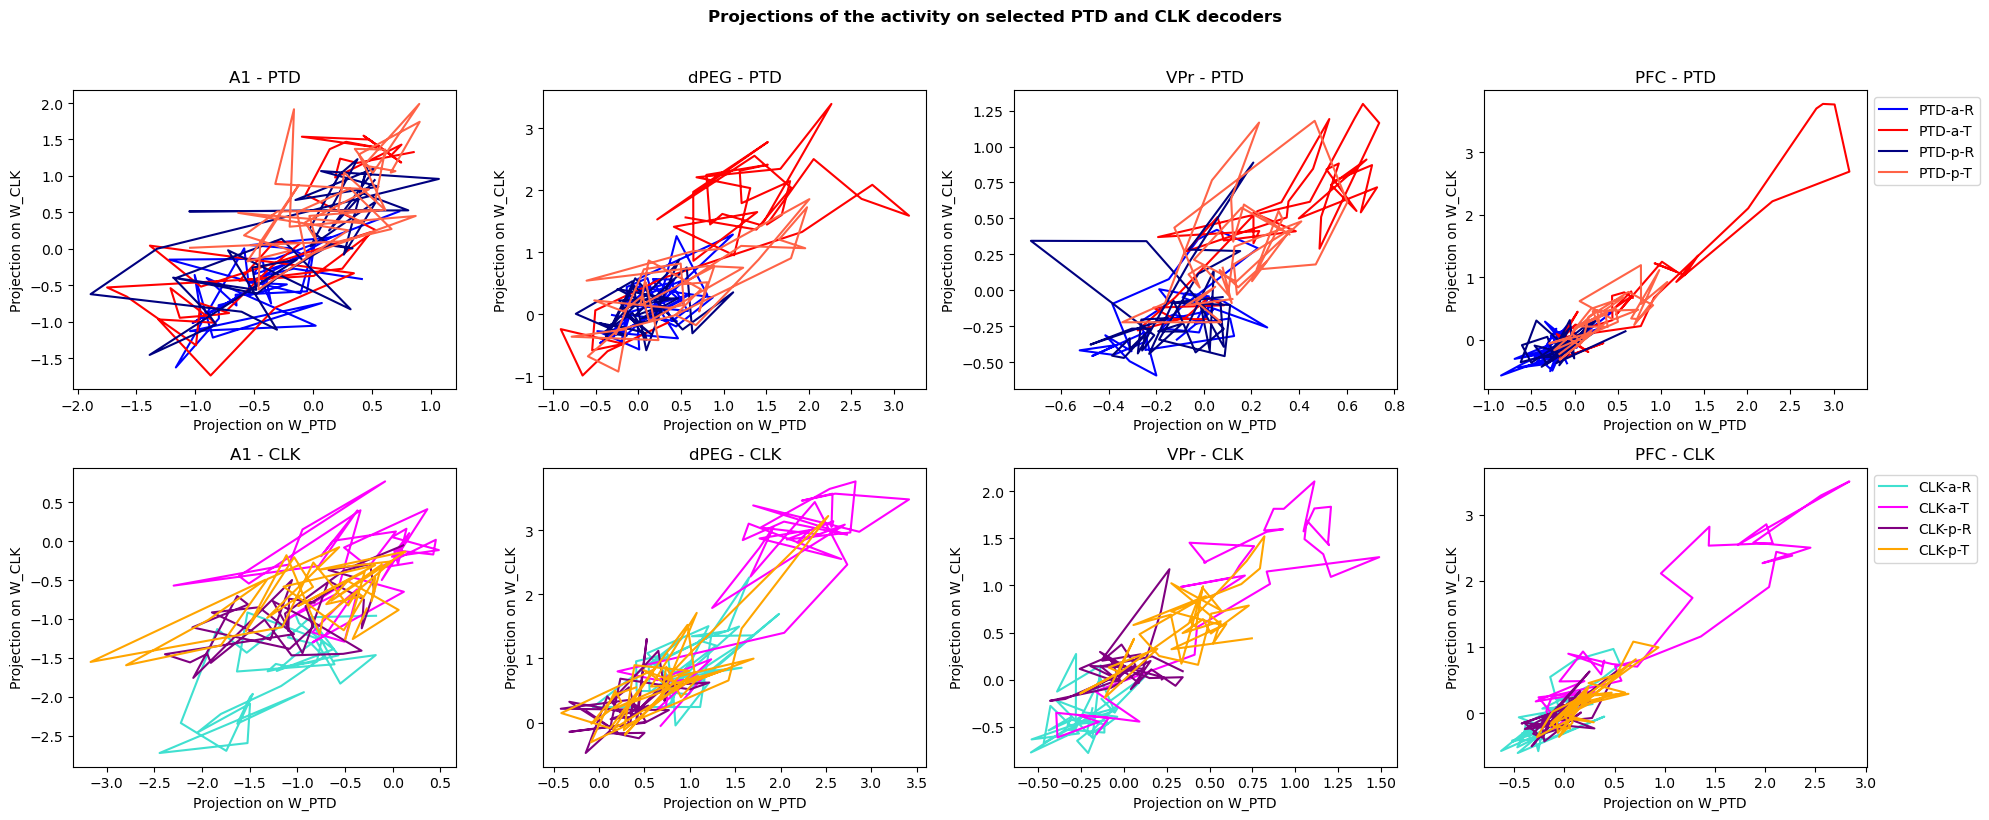

In [14]:
# FIG 2: Evolution in the space (Proj_on_PTD, Proj_on_CLK)

nrows = len(TASKS)
ncols = len(AREAS)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
fig.suptitle("Projections of the activity on selected PTD and CLK decoders", weight='bold', y=1.02)

for i, t in enumerate(TASKS):
    for j, area in enumerate(AREAS):
        ax = axes[i, j]
        for c in CTXS:
            for s in STIMS:
                x_data = P_on_PTD_sel_avg[area][t][c][s]
                y_data = P_on_CLK_sel_avg[area][t][c][s]
                ax.plot(x_data, y_data, label=f"{t}-{c}-{s}", color=colors[t][c][s], linestyle=linestyles['on_PTD'])
                
        ax.set_title(f"{area} - {t}")
        ax.set_xlabel("Projection on W_PTD")
        ax.set_ylabel("Projection on W_CLK")
        if j == ncols - 1:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [19]:
# Import U_low and U_high as numpy arrays

path_save = "/Users/eresther/Documents/Work/multitask-context-dependent-behavior/notebooks_explo/data"

U_low = {area: np.load(f"{path_save}/U_low_{area}.npy") for area in AREAS}
U_high = {area: np.load(f"{path_save}/U_high_{area}.npy") for area in AREAS}

print(U_low["A1"].shape)

(26,)


In [33]:
# Compute the projection restricted to the units in U_low and U_high
# 
P_on_PTD_low = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
P_on_CLK_low = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_PTD_low = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_CLK_low = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_PTD_low = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_CLK_low = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}

P_on_PTD_high = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
P_on_CLK_high = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_PTD_high = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_CLK_high = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_PTD_high = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_CLK_high = {area: {task: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}

for pop in ["low", "high"]:
    if pop == "low":
        P_on_PTD, STD_on_PTD, SEM_on_PTD = P_on_PTD_low, STD_on_PTD_low, SEM_on_PTD_low
        P_on_CLK, STD_on_CLK, SEM_on_CLK = P_on_CLK_low, STD_on_CLK_low, SEM_on_CLK_low
        U = U_low
    else:
        P_on_PTD, STD_on_PTD, SEM_on_PTD = P_on_PTD_high, STD_on_PTD_high, SEM_on_PTD_high
        P_on_CLK, STD_on_CLK, SEM_on_CLK = P_on_CLK_high, STD_on_CLK_high, SEM_on_CLK_high
        U = U_high
    for W_task_sel, P, STD, SEM in zip([W_PTD_sel, W_CLK_sel], [P_on_PTD, P_on_CLK], [STD_on_PTD, STD_on_CLK], [SEM_on_PTD, SEM_on_CLK]):
        for area in AREAS:
            for f in range(nfolds):
                for b in range(get_nbatches(area)):
                        print(f"*** Population: {pop}, Area: {area}, Fold: {f}, Batch: {b} ***")
                        w = W_task_sel[area][f, b] # (nunits,)
                        X_area = X[area].sel(trials=X[area][f'test_{f}'].values) # retain the right test fold (nunits, ntpts, ntrials_test_fold_f)
                        for task in TASKS:
                            for c in CTXS:
                                for s in STIMS:
                                    print(f"-- Task: {task}, Context: {c}, Stimulus: {s}")
                                    x = X_area.sel(trials=(X_area['task'].values==task)&(X_area['ctx'].values==c)&(X_area['stim'].values==s)).values
                                    x_pop = x[U[area]]
                                    w_pop = w[U[area]]
                                    product = w_pop[:,np.newaxis, np.newaxis] * x_pop
                                    dot = np.nansum(product, axis=0)
                                    P[area][task][c][s][:, f, b] = np.nanmean(dot, axis=1)
                                    STD[area][task][c][s][:, f, b] = np.nanstd(dot, axis=1)
                                    SEM[area][task][c][s][:, f, b] = STD[area][task][c][s][:, f, b] / np.sqrt(x_pop.shape[2])
                print("------------")



*** Population: low, Area: A1, Fold: 0, Batch: 0 ***
-- Task: PTD, Context: a, Stimulus: R
-- Task: PTD, Context: a, Stimulus: T
-- Task: PTD, Context: p, Stimulus: R
-- Task: PTD, Context: p, Stimulus: T
-- Task: CLK, Context: a, Stimulus: R
-- Task: CLK, Context: a, Stimulus: T
-- Task: CLK, Context: p, Stimulus: R
-- Task: CLK, Context: p, Stimulus: T
*** Population: low, Area: A1, Fold: 0, Batch: 1 ***
-- Task: PTD, Context: a, Stimulus: R
-- Task: PTD, Context: a, Stimulus: T
-- Task: PTD, Context: p, Stimulus: R
-- Task: PTD, Context: p, Stimulus: T
-- Task: CLK, Context: a, Stimulus: R
-- Task: CLK, Context: a, Stimulus: T
-- Task: CLK, Context: p, Stimulus: R
-- Task: CLK, Context: p, Stimulus: T
------------
*** Population: low, Area: A1, Fold: 1, Batch: 0 ***
-- Task: PTD, Context: a, Stimulus: R
-- Task: PTD, Context: a, Stimulus: T
-- Task: PTD, Context: p, Stimulus: R
-- Task: PTD, Context: p, Stimulus: T
-- Task: CLK, Context: a, Stimulus: R
-- Task: CLK, Context: a, Stim

In [35]:
# Average across folds and batches
P_on_PTD_low_avg = {area: {task: {ctx: {stim: np.nanmean(P_on_PTD_low[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
P_on_CLK_low_avg = {area: {task: {ctx: {stim: np.nanmean(P_on_CLK_low[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_PTD_low_avg = {area: {task: {ctx: {stim: np.nanmean(STD_on_PTD_low[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_CLK_low_avg = {area: {task: {ctx: {stim: np.nanmean(STD_on_CLK_low[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_PTD_low_avg = {area: {task: {ctx: {stim: np.nanmean(SEM_on_PTD_low[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_CLK_low_avg = {area: {task: {ctx: {stim: np.nanmean(SEM_on_CLK_low[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}

P_on_PTD_high_avg = {area: {task: {ctx: {stim: np.nanmean(P_on_PTD_high[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
P_on_CLK_high_avg = {area: {task: {ctx: {stim: np.nanmean(P_on_CLK_high[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_PTD_high_avg = {area: {task: {ctx: {stim: np.nanmean(STD_on_PTD_high[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_on_CLK_high_avg = {area: {task: {ctx: {stim: np.nanmean(STD_on_CLK_high[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_PTD_high_avg = {area: {task: {ctx: {stim: np.nanmean(SEM_on_PTD_high[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_on_CLK_high_avg = {area: {task: {ctx: {stim: np.nanmean(SEM_on_CLK_high[area][task][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}


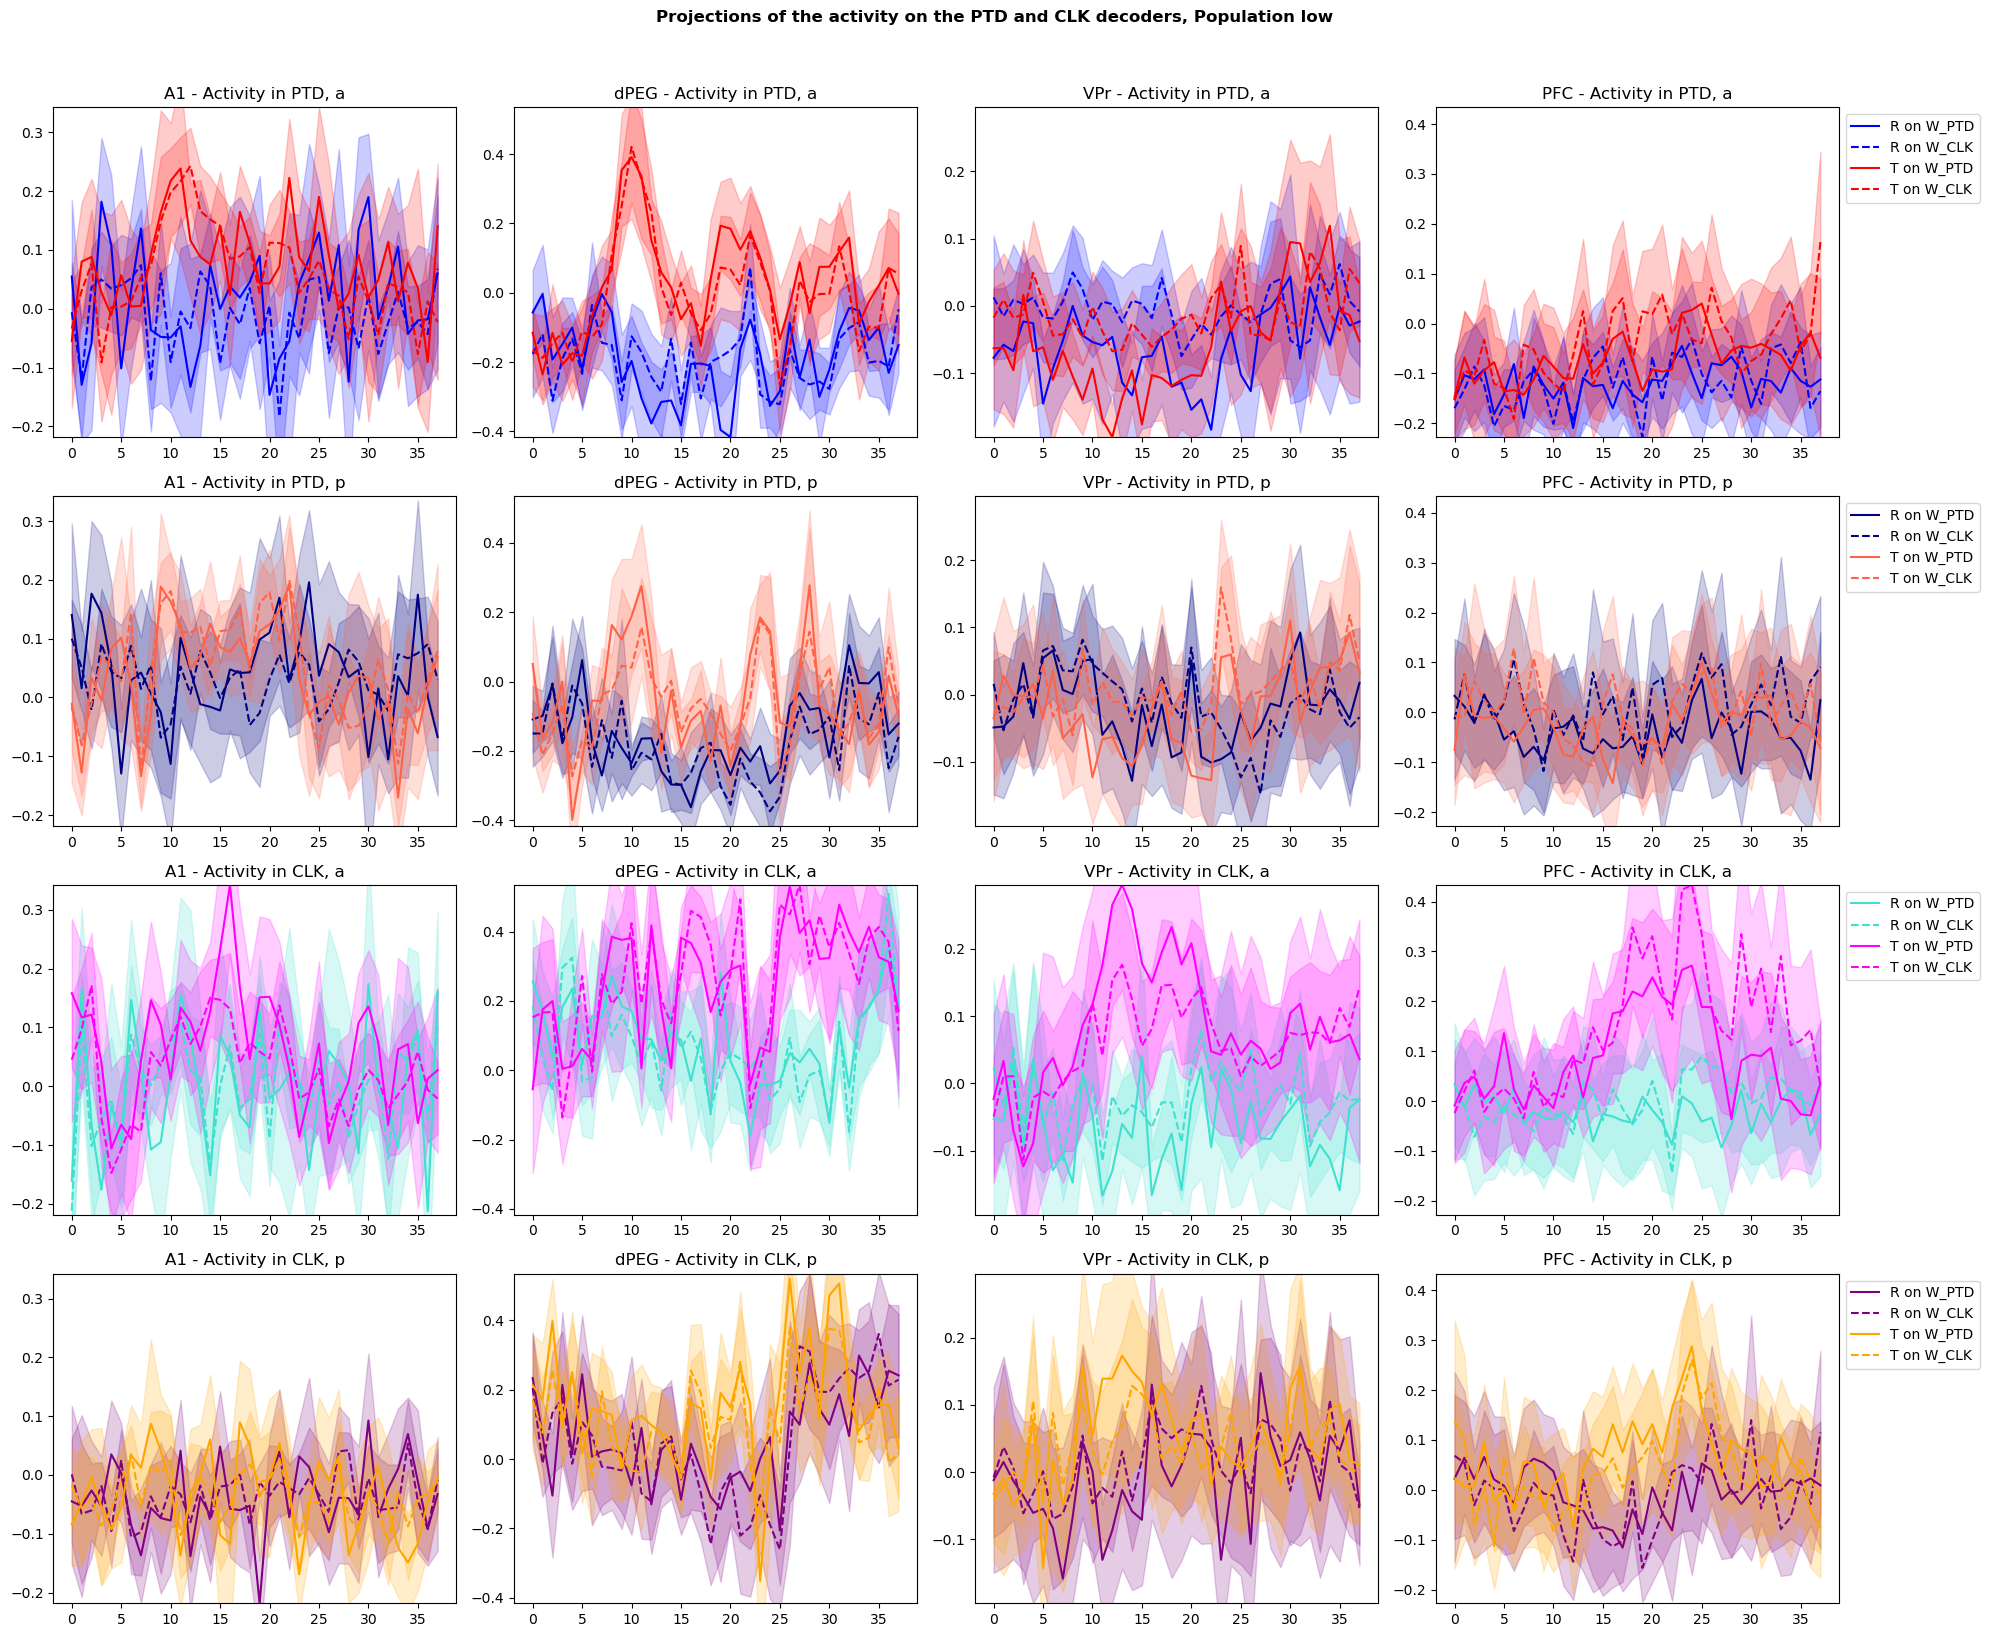

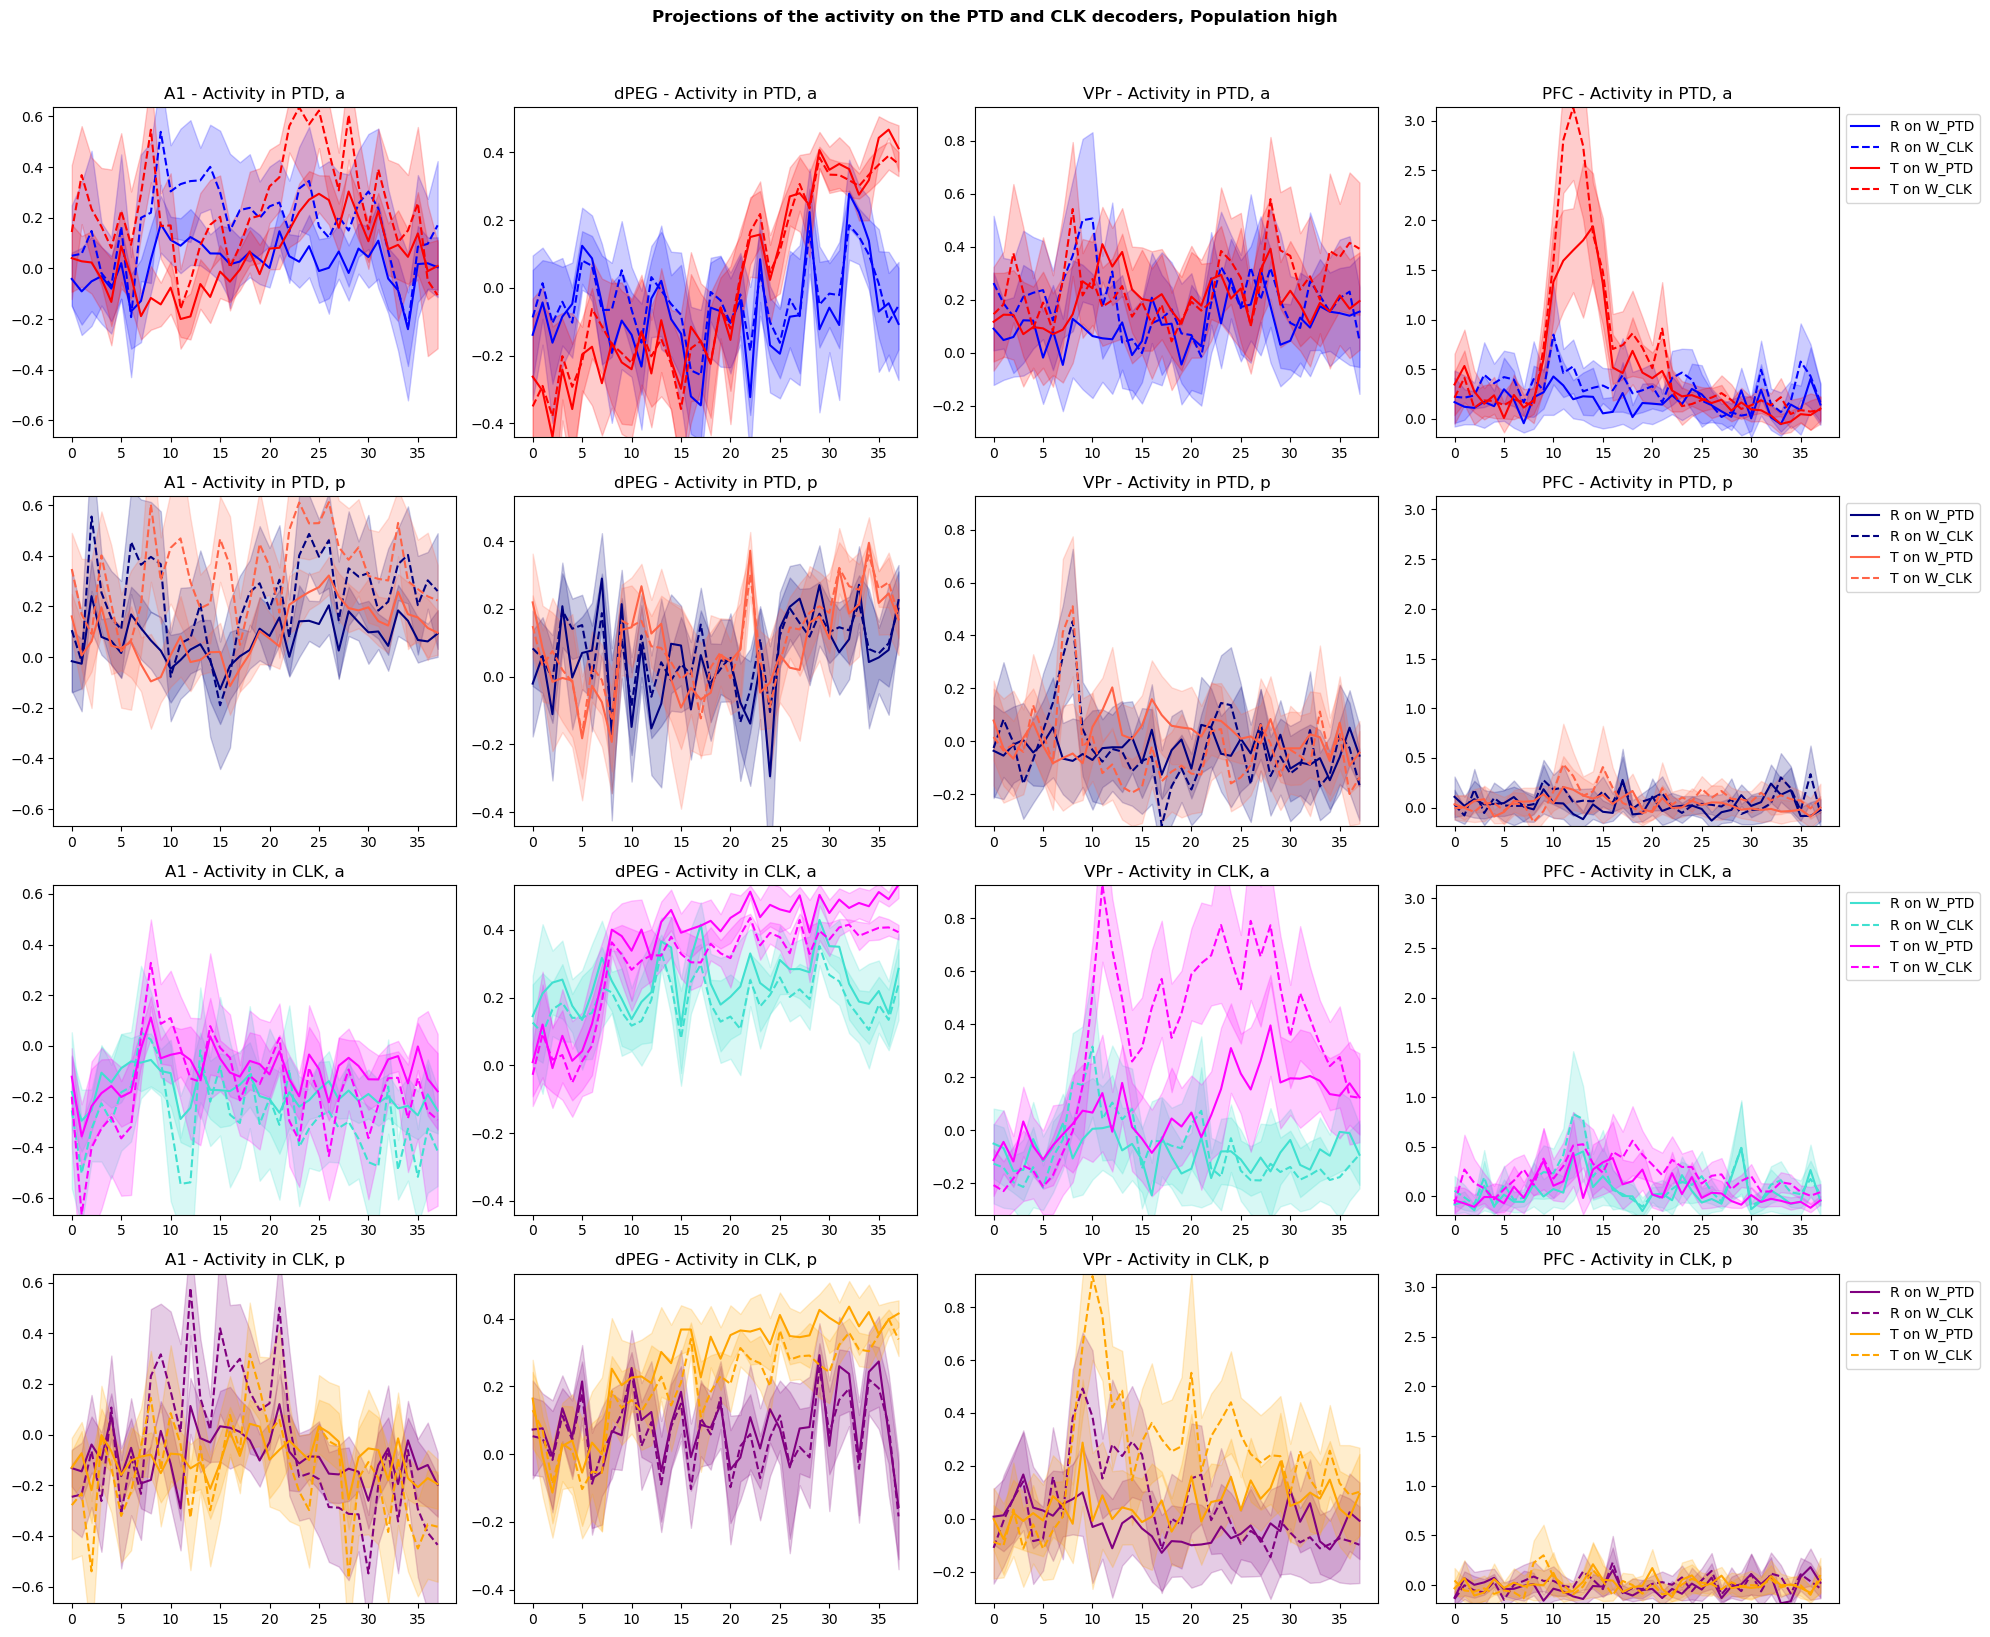

In [36]:
# FIG3: Plot the results

for pop in ["low", "high"]:

    if pop == "low":
        P_on_PTD_avg, P_on_CLK_avg = P_on_PTD_low_avg, P_on_CLK_low_avg
        SEM_on_PTD_avg, SEM_on_CLK_avg = SEM_on_PTD_low_avg, SEM_on_CLK_low_avg
    else:
        P_on_PTD_avg, P_on_CLK_avg = P_on_PTD_high_avg, P_on_CLK_high_avg
        SEM_on_PTD_avg, SEM_on_CLK_avg = SEM_on_PTD_high_avg, SEM_on_CLK_high_avg

    nrows = len(TASKS) * len(CTXS)
    ncols = len(AREAS)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    fig.suptitle(f"Projections of the activity on the PTD and CLK decoders, Population {pop}", weight='bold', y=1.02)

    # Initialize lists to store min and max y-values for each column
    y_min = [np.inf] * ncols
    y_max = [-np.inf] * ncols

    # First pass: determine the global y-axis limits for each column
    for i, t in enumerate(TASKS):
        for j, c in enumerate(CTXS):
            for k, area in enumerate(AREAS):
                for s in STIMS:
                    data_PTD = P_on_PTD_avg[area][t][c][s]
                    data_CLK = P_on_CLK_avg[area][t][c][s]
                    y_min[k] = min(y_min[k], data_PTD.min(), data_CLK.min())
                    y_max[k] = max(y_max[k], data_PTD.max(), data_CLK.max())

    # Second pass: plot the data and set the y-axis limits
    for i, t in enumerate(TASKS):
        for j, c in enumerate(CTXS):
            for k, area in enumerate(AREAS):
                ax = axes[i*len(CTXS)+j, k]
                for s in STIMS:
                    # Plot PTD data with shaded area for STD
                    ax.plot(P_on_PTD_avg[area][t][c][s], label=f"{s} on W_PTD", color=colors[t][c][s], linestyle=linestyles['on_PTD'])
                    ax.fill_between(range(len(P_on_PTD_avg[area][t][c][s])), 
                                    P_on_PTD_avg[area][t][c][s] - SEM_on_PTD_avg[area][t][c][s], 
                                    P_on_PTD_avg[area][t][c][s] + SEM_on_PTD_avg[area][t][c][s], 
                                    color=colors[t][c][s], alpha=0.2)
                    
                    # Plot CLK data with shaded area for STD
                    ax.plot(P_on_CLK_avg[area][t][c][s], label=f"{s} on W_CLK", color=colors[t][c][s], linestyle=linestyles['on_CLK'])
                    ax.fill_between(range(len(P_on_CLK_avg[area][t][c][s])), 
                                    P_on_CLK_avg[area][t][c][s] - SEM_on_CLK_avg[area][t][c][s], 
                                    P_on_CLK_avg[area][t][c][s] + SEM_on_CLK_avg[area][t][c][s], 
                                    color=colors[t][c][s], alpha=0.2)
                    
                ax.set_title(f"{area} - Activity in {t}, {c}")
                ax.set_ylim(y_min[k], y_max[k])

            if area == "PFC":
                # Add a single legend in this plot for the entire row
                ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


    plt.tight_layout()
    plt.show()